# PROV Templates in Python

     Author: Stephan Kindermann
     Affiliation: DKRZ
     Community: ENES (Earth System Sciences)
     Version: 0.1 (July 2018)
    
**Motivation:**
* PROV template expansion currently is only supported by the **provconvert** java tool.
* initial generation and integration of PROV descriptions as part of ENES community efforts 
is oftenly done by adopting interactive languages like python.
* The sharing PROV adoption narratives is well supported by using jupyter notebooks and python.
* Core infrastructure services in ENES are implemented using python. 
* **provenvert** output can not be imported using the python prov package (only supporting PROV-json serialization format for import)
* The java based **provconvert** tool thus is difficult to exploit in ENES use cases
* What is needed in the short term are simple python based wrappers integrated in our
community workflow, generating prov descriptions best on the basis of prov template instantiations.
* The idea of using PROV templates yet is helpful, the only problem is to enable tool based generation and instantiation in an interactive setting without the requirement to use **provconvert** and do use Java for tool based template use cases. 

**Approach taken**
Thus a simple approach is taken which on the one hand side allows to use PROV templates and which
on the other hand side allows for pure python based template instantiations.
Drawback is that the elaborated prov expansion algorithm can not be used - yet to make the expansion explicit on the basis of python can also seen as an advantage as the community PROV adopters don't need to dig into the expansion algorithm implemented as part of provconvert (and eventual errors therein).

The approach taken is illustrated in the following:   
* PROV templates (being standard PROV documents) are generated in Python based on the prov library alongside PROV template instances.
* A very simple instantiation algorithm is used to instantiate templates based on dictionaries containing the variable settings .. this instantiation algorithm is stepwise expanded


## Generate a PROV template
PROV templates are generated in functions with all RROV variables as parameters.
This function is called with prov template variable names to generate prov templates. When called with instances the result is an prov document corresponding to the instantiated prov template.

In the following the approach is illustrated based on a concrete examplec (corresponding to the first example in the provconvert tutorial). 

In [92]:
# Define the variable parts in the template as dictionary keys
# dictionary values are the prov template variable bindings in one case
# and correspond to the variable instance settings in the other case
import prov.model as prov
template_dict = {
    'var_author':'var:author',
    'var_value':'var:value',
    'var_name':'var:name',
    'var_quote':'var:quote'
}
instance_dict = {
    'var:author':'orcid:0000-0002-3494-120X',
    'var:value':'A Little Provenance Goes a Long Way',
    'var:name':'Luc Moreau',
    'var:quote':'ex:quote1'
}

In [5]:
# test for use of default namespace
document = prov.ProvDocument()
document.set_default_namespace('http://example.org/0/')
                               
quote = document.entity('tst')                              

In [101]:
def new_provdoc():
    document = prov.ProvDocument()
    # ----- namspace settings --------------------------------------------------
    document.add_namespace('prov','http://www.w3.org/ns/prov#')
    document.add_namespace('var','http://openprovenance.org/var#>')
    document.add_namespace('vargen','http://openprovenance.org/vargen#')
    document.add_namespace('tmpl','http://openprovenance.org/tmpl#')
    document.add_namespace('foaf','http://xmlns.com/foaf/0.1/')
    document.add_namespace('ex', 'http://example.org/')
    document.add_namespace('orcid','http://orcid.org/')

    document.set_default_namespace('http://example.org/0/')
    #document.add_namespace('rdf','http://www.w3.org/1999/02/22-rdf-syntax-ns#')
    #document.add_namespace('rdfs','http://www.w3.org/2000/01/rdf-schema#')
    #document.add_namespace('xsd','http://www.w3.org/2001/XMLSchema#')
    #document.add_namespace('ex1', 'http://example.org/1/')
    #document.add_namespace('ex2', 'http://example.org/2/')
    # ----------------------------------------------------------------------------
    return document

In [73]:
def make_prov(var_value,var_name,var_quote,var_author): 
    # for enes data ingest use case: use information from dkrz_forms/config/workflow_steps.py
    document = prov.ProvDocument()
    # ----- namspace settings --------------------------------------------------
    document.add_namespace('prov','http://www.w3.org/ns/prov#')
    document.add_namespace('var','http://openprovenance.org/var#>')
    document.add_namespace('vargen','http://openprovenance.org/vargen#')
    document.add_namespace('tmpl','http://openprovenance.org/tmpl#')
    document.add_namespace('foaf','http://xmlns.com/foaf/0.1/')
    document.add_namespace('ex', 'http://example.org/')
    document.add_namespace('orcid','http://orcid.org/')

    #document.set_default_namespace('http://example.org/0/')
    #document.add_namespace('rdf','http://www.w3.org/1999/02/22-rdf-syntax-ns#')
    #document.add_namespace('rdfs','http://www.w3.org/2000/01/rdf-schema#')
    #document.add_namespace('xsd','http://www.w3.org/2001/XMLSchema#')
    #document.add_namespace('ex1', 'http://example.org/1/')
    #document.add_namespace('ex2', 'http://example.org/2/')
    # ----------------------------------------------------------------------------

    bundle = document.bundle('vargen:bundleid')
    #bundle.set_default_namespace('http://example.org/0/')
    quote = bundle.entity(var_quote,(
         ('prov:value',var_value),
    ))    

    author = bundle.entity(var_author,(
        (prov.PROV_TYPE, "prov:Person"),
        ('foaf:name',var_name)
    )) 

    bundle.wasAttributedTo(var_quote,var_author)
    
    return document

def save_and_show(filename):
    doc1 = make_prov(**template_dict)
    print(doc1.get_provn())

    with open(filename, 'w') as provn_file:
        provn_file.write(doc1.get_provn())
    
    print("------")
    print("saved in file:",filename)
    return doc1

doc1 = save_and_show('/home/stephan/test/xxxx.provn')

document
  prefix var <http://openprovenance.org/var#>>
  prefix vargen <http://openprovenance.org/vargen#>
  prefix tmpl <http://openprovenance.org/tmpl#>
  prefix foaf <http://xmlns.com/foaf/0.1/>
  prefix ex <http://example.org/>
  prefix orcid <http://orcid.org/>
  
  bundle vargen:bundleid
    entity(var:quote, [prov:value="var:value"])
    entity(var:author, [prov:type="prov:Person", foaf:name="var:name"])
    wasAttributedTo(var:quote, var:author)
  endBundle
endDocument
------
saved in file: /home/stephan/test/xxxx.provn


In [112]:
bundles = doc1.bundles
for k in bundles:
    bundle = k
    print(k) 

<ProvBundle: vargen:bundleid>


In [117]:


tst = {"'prov:type'": 'prov:Person', "'foaf:name'": 'Luc Moreau'}

for key,val in tst.items():
    print(key)
    print(key.replace("'",""))

'prov:type'
prov:type
'foaf:name'
foaf:name


In [113]:
k.identifier

<QualifiedName: vargen:bundleid>

In [114]:
doc1.bundle(k.identifier)

ProvException: A bundle with that identifier already exists

## Compare generated PROV template with original example: 

In [ ]:
# %load Downloads/ProvToolbox-Tutorial4-0.7.0/src/main/resources/template1.provn

document

  prefix var <http://openprovenance.org/var#>
  prefix vargen <http://openprovenance.org/vargen#>
  prefix tmpl <http://openprovenance.org/tmpl#>

  prefix foaf <http://xmlns.com/foaf/0.1/>
  
  bundle vargen:bundleId
    entity(var:quote, [prov:value='var:value'])
    entity(var:author, [prov:type='prov:Person', foaf:name='var:name'])
    wasAttributedTo(var:quote,var:author)
  endBundle

endDocument


## Instantiate PROV template 



In [14]:
doc2 = make_prov(**instance_dict)
print(doc2.get_provn())

ex:quote1
document
  prefix var <http://openprovenance.org/var#>>
  prefix vargen <http://openprovenance.org/vargen#>
  prefix tmpl <http://openprovenance.org/tmpl#>
  prefix foaf <http://xmlns.com/foaf/0.1/>
  prefix ex <http://example.org/>
  
  bundle vargen:bundleid
    entity(ex:quote1, [prov:value="A Little Provenance Goes a Long Way"])
    entity(ex:0000-0002-3494-120X, [prov:type="prov:Person", foaf:name="Luc Moreau"])
    wasAttributedTo(ex:quote1, ex:0000-0002-3494-120X)
  endBundle
endDocument


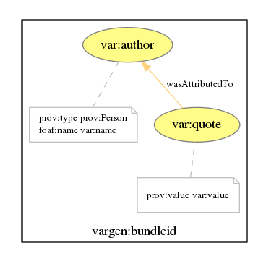

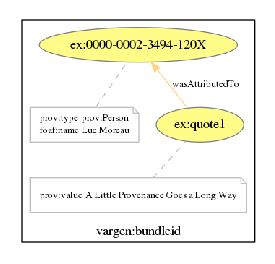

In [25]:
%matplotlib  inline
doc1.plot()
doc2.plot()

In [ ]:
# take same instantiation as in the tutorial:
# %load Downloads/ProvToolbox-Tutorial4-0.7.0/src/main/resources/binding1.ttl
@prefix prov: <http://www.w3.org/ns/prov#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix tmpl: <http://openprovenance.org/tmpl#> .
@prefix var: <http://openprovenance.org/var#> .
@prefix ex: <http://example.com/#> .

var:author a prov:Entity;
           tmpl:value_0 <http://orcid.org/0000-0002-3494-120X>.
var:name   a prov:Entity;
           tmpl:2dvalue_0_0 "Luc Moreau".
var:quote  a prov:Entity;
           tmpl:value_0 ex:quote1.
var:value  a prov:Entity;
           tmpl:2dvalue_0_0 "A Little Provenance Goes a Long Way".



## Instantiate PROV template using provconvert and compare results

In [15]:
!provconvert -infile test/template1.provn -bindings test/binding1.ttl -outfile test/doc1.provn

bindings version is 1


In [ ]:
# %load test/doc1.provn
document
bundle uuid:b07bc92f-f16a-443c-9e0a-3bda4063fc10
prefix foaf <http://xmlns.com/foaf/0.1/>
prefix pre_0 <http://orcid.org/>
prefix ex <http://example.com/#>
prefix uuid <urn:uuid:>

entity(ex:quote1,[prov:value = "A Little Provenance Goes a Long Way" %% xsd:string])
entity(pre_0:0000-0002-3494-120X,[prov:type = 'prov:Person', foaf:name = "Luc Moreau" %% xsd:string])
wasAttributedTo(ex:quote1, pre_0:0000-0002-3494-120X)
endBundle
endDocument


In [18]:
!provconvert -infile test/doc1.provn -outfile test/doc1.png


In [19]:
!provconvert -infile test/template1.provn -outfile test/template1.png

In [ ]:
# %load Downloads/ProvToolbox-Tutorial4-0.7.0/target/doc1.provn
document
bundle uuid:4c7236d5-6420-4a88-b192-6089e27aa88e
prefix foaf <http://xmlns.com/foaf/0.1/>
prefix pre_0 <http://orcid.org/>
prefix ex <http://example.com/#>
prefix uuid <urn:uuid:>

entity(ex:quote1,[prov:value = "A Little Provenance Goes a Long Way" %% xsd:string])
entity(pre_0:0000-0002-3494-120X,[prov:type = 'prov:Person', foaf:name = "Luc Moreau" %% xsd:string])
wasAttributedTo(ex:quote1, pre_0:0000-0002-3494-120X)
endBundle
endDocument


In [ ]:
#------------------------to be removeed ------------------------------------

In [ ]:
%matplotlib inline
document.plot()

In [ ]:
!cat Downloads/ProvToolbox-Tutorial4-0.7.0/Makefile

# Show provconvert result to compare

![in](./test/doc1.png)
![out](./test/doc2.png)

In [ ]:
#def set_template_vars(var_dict):
#    for var, value in var_dict.items():
#        globals()[var] = value

# Test: PROV Template Instantiation class implementation

In [ ]:
# idea: input: template prov doc
#       param: instantiation settings (ttl)
#       output: instantiated prov doc
# impl: loop over prov entities and parameters and replace (initial version)
#       later: more complex instantiation rules implementation



class PROVT(object):
    ''' Form object with attributes defined by a configurable project dictionary
    '''
    __metaclass__=abc.ABCMeta
    def __init__(self, adict):
        """Convert a dictionary to a Form Object

        :param adict: a (hierarchical) python dictionary
        :returns Form objcet: a hierachical Form object with attributes set based on input dictionary
        """
        self.__dict__.update(adict)
        ## self.__dict__[key] = AttributeDict(**mydict)  ??
        for k, v in adict.items():
           if isinstance(v, dict):
              self.__dict__[k] = PROVT(v)

    
    def make_prov(d,)
    
    
    def __repr__(self):
        """
        """
        return "PROVT object "

    def __str__(self):
        return "PROVT object: %s" %  self.__dict__



In [3]:
def test(*par):
    print(par)
    
par =(1,2,3) 
test(*par)

(1, 2, 3)


In [67]:
from prov.model import ProvDocument
from prov.dot import prov_to_dot
from IPython.display import Image
from prov.model import (
    PROV_ACTIVITY, PROV_AGENT, PROV_ALTERNATE, PROV_ASSOCIATION,
    PROV_ATTRIBUTION, PROV_BUNDLE, PROV_COMMUNICATION, PROV_DERIVATION,
    PROV_DELEGATION, PROV_ENTITY, PROV_GENERATION, PROV_INFLUENCE,
    PROV_INVALIDATION, PROV_END, PROV_MEMBERSHIP, PROV_MENTION,
    PROV_SPECIALIZATION, PROV_START, PROV_USAGE, Identifier,
    PROV_ATTRIBUTE_QNAMES, sorted_attributes, ProvException
)

import six

r_list = []
records = doc1.get_records()
r_list.append(records)

blist = list(doc1.bundles)
for bundle in blist:
   r_list.append(bundle.records) 
print(r_list)


for r in r_list:
    if r: 
        for pp in r:
           print(pp)
           if pp.is_element():
                print("Element")
                print(pp.attributes)
                for (qn,val) in pp.attributes:
                    print(qn,val)
                    pp.add_attributes({qn:'ex:tst'})
                    print("added attribute to ",qn,val)
           if pp.is_relation():
                print("Relation")
          
           #print(pp.identifier.localpart) 
           #print(pp.value) 

[[], [<ProvEntity: var:quote>, <ProvEntity: var:author>, <ProvAttribution: (var:quote, var:author)>]]
entity(var:quote, [prov:value="ex:tst", prov:value="var:value"])
Element
[(<QualifiedName: prov:value>, 'ex:tst'), (<QualifiedName: prov:value>, 'var:value')]
prov:value ex:tst
added attribute to  prov:value ex:tst
prov:value var:value
added attribute to  prov:value var:value
entity(var:author, [prov:type="prov:Person", prov:type="ex:tst", foaf:name="ex:tst", foaf:name="var:name"])
Element
[(<QualifiedName: prov:type>, 'prov:Person'), (<QualifiedName: prov:type>, 'ex:tst'), (<QualifiedName: foaf:name>, 'ex:tst'), (<QualifiedName: foaf:name>, 'var:name')]
prov:type prov:Person
added attribute to  prov:type prov:Person
prov:type ex:tst
added attribute to  prov:type ex:tst
foaf:name ex:tst
added attribute to  foaf:name ex:tst
foaf:name var:name
added attribute to  foaf:name var:name
wasAttributedTo(var:quote, var:author)
Relation


In [68]:
for r in r_list:
    if r: 
        for pp in r:
           print(pp)

entity(var:quote, [prov:value="ex:tst", prov:value="var:value"])
entity(var:author, [prov:type="prov:Person", prov:type="ex:tst", foaf:name="ex:tst", foaf:name="var:name"])
wasAttributedTo(var:quote, var:author)


In [63]:
print(doc1.get_provn())

document
  prefix var <http://openprovenance.org/var#>>
  prefix vargen <http://openprovenance.org/vargen#>
  prefix tmpl <http://openprovenance.org/tmpl#>
  prefix foaf <http://xmlns.com/foaf/0.1/>
  prefix ex <http://example.org/>
  prefix orcid <http://orcid.org/>
  
  bundle vargen:bundleid
    prefix foaf <http://xmlns.com/foaf/0.1/>
    
    entity(var:quote, [prov:value="ex:tst", prov:value="var:value"])
    entity(var:author, [prov:type="prov:Person", prov:type="ex:tst", foaf:name="ex:tst", foaf:name="var:name"])
    wasAttributedTo(var:quote, var:author)
  endBundle
endDocument


In [46]:
#record = records[0]
record = records[-1]
#record.value
record.args
record.attributes
record.extra_attributes


[]

In [69]:
print(record.attributes)
eid = record.identifier
print(eid)
eid.localpart
eid.namespace

[(<QualifiedName: prov:entity>, <QualifiedName: var:quote>), (<QualifiedName: prov:agent>, <QualifiedName: var:author>)]
None


AttributeError: 'NoneType' object has no attribute 'localpart'

In [76]:
print(doc1.records)

[]


In [106]:
from prov.model import ProvDocument
from prov.dot import prov_to_dot
from IPython.display import Image
from prov.model import (
    PROV_ACTIVITY, PROV_AGENT, PROV_ALTERNATE, PROV_ASSOCIATION,
    PROV_ATTRIBUTION, PROV_BUNDLE, PROV_COMMUNICATION, PROV_DERIVATION,
    PROV_DELEGATION, PROV_ENTITY, PROV_GENERATION, PROV_INFLUENCE,
    PROV_INVALIDATION, PROV_END, PROV_MEMBERSHIP, PROV_MENTION,
    PROV_SPECIALIZATION, PROV_START, PROV_USAGE, Identifier,
    PROV_ATTRIBUTE_QNAMES, sorted_attributes, ProvException
)

import six
import itertools

def match(eid,mdict):
    if eid in mdict:
        return mdict[eid]
    else:
        print("Warning: matching of key not successful: ",eid)
        return eid
    

def gen_graph_model(prov_doc):
     
    new_doc = new_provdoc() 
    
    relations = []
    nodes = []
    new_nodes=[]
    r_list = []
    
    records = prov_doc.get_records()
    
    r_list.append(records)

    blist = list(prov_doc.bundles)
    for bundle in blist:
        r_list.append(bundle.records)
        #print(bundle.records)
    
    fr_list = list(itertools.chain(*r_list))

    for rec in fr_list:
         if rec.is_element():
            nodes.append(rec)
            #print(rec)
         else:
            relations.append(rec)
            
    for rec in nodes:
        eid = rec.identifier
        attr = rec.attributes
        args = rec.args
        
        #print(eid)
        #print(attr)
        #print(args)
        neid = match(eid._str,instance_dict)
        print("match: ",neid)
        new_node = new_doc.entity(Identifier(neid))
        new_nodes.append(new_node)
        
        
    return new_doc

new = gen_graph_model(doc1)
print(doc1.get_provn())
print(new.get_provn())
               



match:  ex:quote1
match:  orcid:0000-0002-3494-120X
document
  prefix var <http://openprovenance.org/var#>>
  prefix vargen <http://openprovenance.org/vargen#>
  prefix tmpl <http://openprovenance.org/tmpl#>
  prefix foaf <http://xmlns.com/foaf/0.1/>
  prefix ex <http://example.org/>
  prefix orcid <http://orcid.org/>
  
  bundle vargen:bundleid
    entity(var:quote, [prov:value="var:value"])
    entity(var:author, [prov:type="prov:Person", foaf:name="var:name"])
    wasAttributedTo(var:quote, var:author)
  endBundle
endDocument
document
  default <http://example.org/0/>
  prefix var <http://openprovenance.org/var#>>
  prefix vargen <http://openprovenance.org/vargen#>
  prefix tmpl <http://openprovenance.org/tmpl#>
  prefix foaf <http://xmlns.com/foaf/0.1/>
  prefix ex <http://example.org/>
  prefix orcid <http://orcid.org/>
  
  entity(ex:quote1)
  entity(orcid:0000-0002-3494-120X)
endDocument


In [94]:
match("var:quote",instance_dict)

'ex:quote1'

In [ ]:

    for rec in relations:
                args = rec.args
                # skipping empty records
                if not args:
                    continue
                # picking element nodes
                nodes = [
                    value for attr_name, value in rec.formal_attributes
                    if attr_name in PROV_ATTRIBUTE_QNAMES
                ]
                other_attributes = [
                    (attr_name, value) for attr_name, value in rec.attributes
                    if attr_name not in PROV_ATTRIBUTE_QNAMES
                ]
    return (nodes,other_attributes)
                